<a href="https://colab.research.google.com/github/giabao18/Chest-X-Ray-Pneumonia-Classifier/blob/main/Chest_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, our focus is on fine-tuning the VGG16 architecture for Pneumonia Detection. With the critical importance of early diagnosis in treating pneumonia, we delve into transfer learning techniques to optimize VGG16's performance. Pneumonia, a respiratory ailment with significant health implications, requires accurate identification from chest X-rays for effective medical intervention. Our objective is to adapt VGG16's learned features to distinguish between normal and pneumonia-infected images, enhancing diagnostic precision. Through meticulous data preprocessing, model customization, and performance assessment, we aim to refine VGG16 for improved pneumonia detection.

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

! unzip "chest-xray-pneumonia.zip"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  infl

In [ ]:
import os
import random
import itertools
from PIL import Image

#--------------------------------------------------------------------------------------#

import numpy as np
import pandas as pd

#--------------------------------------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#--------------------------------------------------------------------------------------#

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#--------------------------------------------------------------------------------------#

import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(f'Tensorflow Version: {tf.__version__}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.15.0
Num GPUs Available:  1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In this part, we'll prepare the data for analysis and modeling. We'll preprocess it and ensure it's in a suitable format. Then, we'll visualize it to gain a better understanding. This will help us make smarter choices when building our pneumonia detection models.



In [ ]:
def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}

    folders = os.listdir(path)

    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)

        for file in files:
            filepath = os.path.join(folderpath, file)

            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    return pd.DataFrame(data)

#--------------------------------------------------------------------------------------#

def set_seed(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)

In [ ]:
train_path = '/content/chest_xray/train'
val_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'

train_df = generate_dataset(train_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
val_df = generate_dataset(val_path).sample(frac = 1, random_state = 0).reset_index(drop = True)
test_df = generate_dataset(test_path).sample(frac = 1, random_state = 0).reset_index(drop = True)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (5216, 2): 
                                             imgpath     labels
0  /content/chest_xray/train/PNEUMONIA/person1670...  PNEUMONIA
1  /content/chest_xray/train/PNEUMONIA/person295_...  PNEUMONIA
2  /content/chest_xray/train/PNEUMONIA/person1696...  PNEUMONIA
3  /content/chest_xray/train/PNEUMONIA/person738_...  PNEUMONIA
4  /content/chest_xray/train/NORMAL/IM-0369-0001....     NORMAL

Validation Dataframe of shape (16, 2): 
                                             imgpath     labels
0  /content/chest_xray/val/NORMAL/NORMAL2-IM-1427...     NORMAL
1  /content/chest_xray/val/NORMAL/NORMAL2-IM-1431...     NORMAL
2  /content/chest_xray/val/PNEUMONIA/person1951_b...  PNEUMONIA
3  /content/chest_xray/val/PNEUMONIA/person1950_b...  PNEUMONIA
4  /content/chest_xray/val/PNEUMONIA/person1947_b...  PNEUMONIA

Testing Dataframe of shape (624, 2): 
                                             imgpath     labels
0  /content/chest_xray/test/PNEUMONIA/person90_

To structure the given images into a dataset, we'll create a table with two columns: "imgpath" and "label". The "imgpath" column will contain the file paths to each image, serving as a reference to their locations in our storage. Meanwhile, the "label" column will assign a category to each image, distinguishing between normal chest X-rays and those indicating pneumonia. This organization facilitates efficient access to the images during model training and evaluation. By structuring the dataset in this manner, we establish a clear association between images and their corresponding labels, laying the groundwork for effective development and utilization of our pneumonia detection model. In this section, we'll use visuals to learn more about our dataset. We'll look at pictures of normal and pneumonia X-rays and see how many of each we have. This will help us understand the dataset better and make better decisions when we're building our pneumonia detection models.

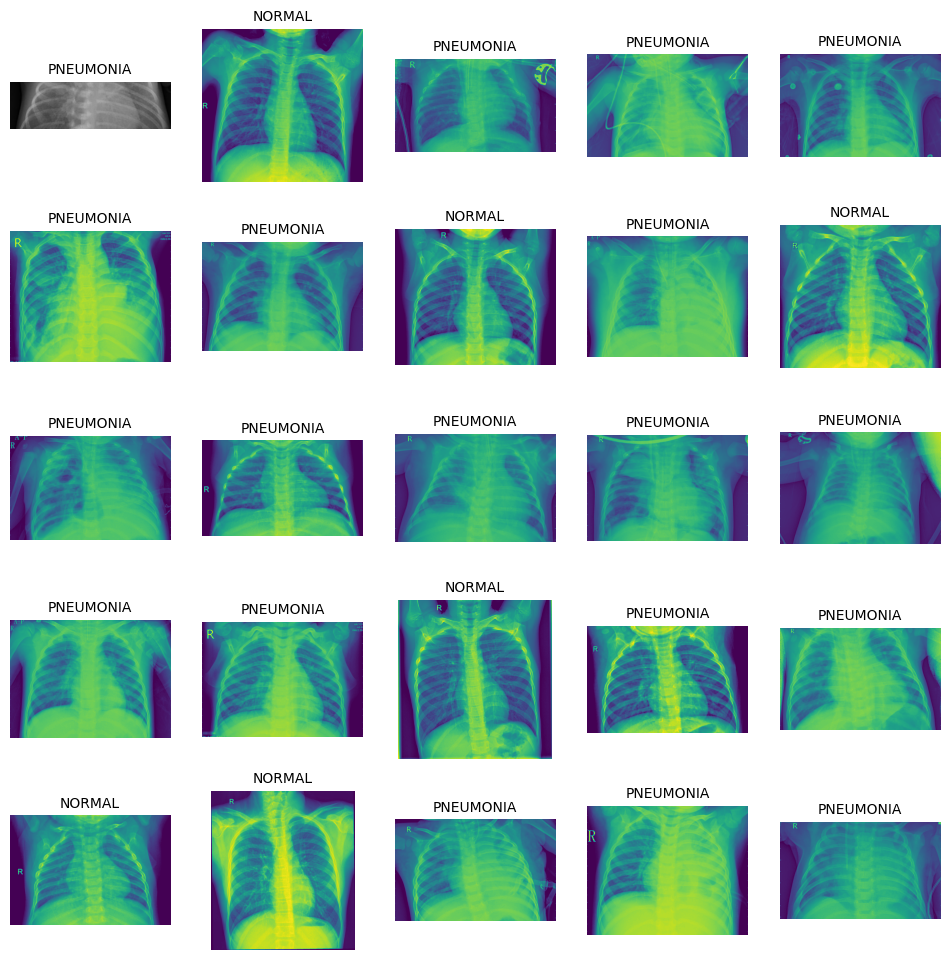

In [ ]:
rows = 5
cols = 5

dataset = pd.concat([train_df, test_df, val_df])

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

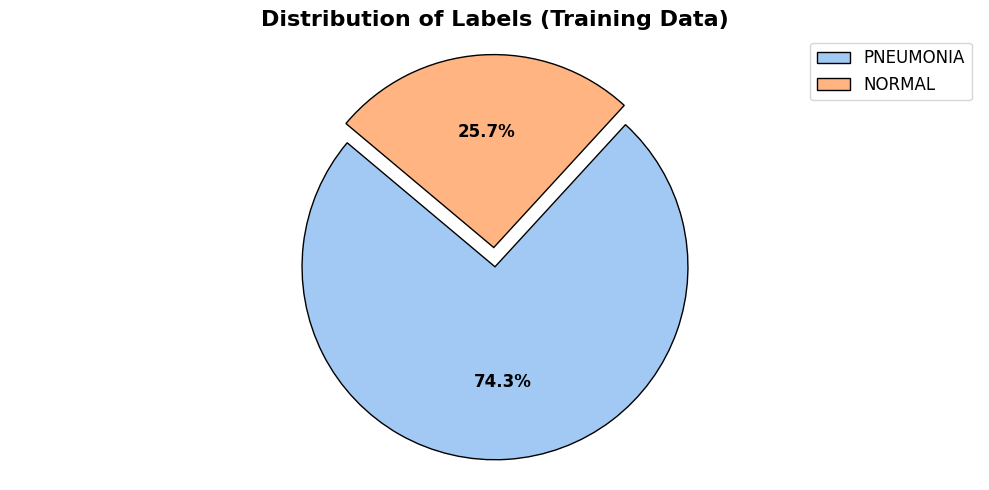

In [ ]:
dataset = train_df

fig, ax = plt.subplots(figsize = (10, 5))

labels = dataset['labels'].value_counts().index
sizes = dataset['labels'].value_counts().values
colors = sns.color_palette('pastel')

wedges, texts, autotexts = ax.pie(sizes, colors = colors,
                                  autopct = '%1.1f%%', startangle = 140,
                                  explode = (0.1, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels (Training Data)', fontsize = 16, fontweight = 'bold')
ax.axis('equal')
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

As anticipated, class imbalances are common in medical datasets, and ours is no exception. To address this, we'll employ image augmentation techniques to ensure our model doesn't develop biases towards any particular class. By augmenting the data, we aim to balance the representation of normal and pneumonia X-rays, thereby improving the model's ability to generalize across both classes effectively.

In [ ]:
%%time

BATCH_SIZE = 16
IMG_SHAPE = (128, 128)
SEED = 0
EPOCHS = 30

traingen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 10,
                              width_shift_range = 0.02,
                              height_shift_range = 0.02,
                              zoom_range = 0.05,
                              horizontal_flip = True)

testgen = ImageDataGenerator(rescale = 1./255)

train_images = traingen.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels',
                                            class_mode = 'binary', color_mode = 'rgb',
                                            batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                            shuffle = True, seed = SEED)

val_images = testgen.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels',
                                         class_mode = 'binary', color_mode = 'rgb',
                                         batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                         shuffle = False)

test_images = testgen.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels',
                                          class_mode = 'binary', color_mode = 'rgb',
                                          batch_size = BATCH_SIZE, target_size = IMG_SHAPE,
                                          shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
CPU times: user 42.7 ms, sys: 17.8 ms, total: 60.6 ms
Wall time: 63.9 ms


Our starting model for pneumonia detection is VGG16, a reliable convolutional neural network known for its effectiveness in image tasks. We'll fine-tune VGG16 to better suit our pneumonia detection task, aiming for accurate identification of normal and pneumonia-infected chest X-ray images. This process ensures our model adapts well to the complexities of pneumonia classification, striving for high accuracy in diagnosis.

In [ ]:
base_model = VGG16(include_top = False, weights = 'imagenet',
                   input_shape = IMG_SHAPE + (3,), pooling = 'avg')

for layer in base_model.layers[:-10]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    Input(shape = IMG_SHAPE + (3,), name = 'input_layer'),
    base_model,

    BatchNormalization(),

    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4, seed = SEED),

    Dense(1, activation = 'sigmoid', name = 'output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
%%time

set_seed(SEED)

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_images, validation_data = val_images,
                    epochs = EPOCHS, callbacks = [model_es, model_rlr])

Epoch 1/30
326/326 [==============================] - 84s 256ms/step - loss: 0.2922 - accuracy: 0.9505 - val_loss: 0.7045 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
326/326 [==============================] - 68s 209ms/step - loss: 0.2003 - accuracy: 0.9517 - val_loss: 4.7938 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
326/326 [==============================] - 70s 214ms/step - loss: 0.1335 - accuracy: 0.9670 - val_loss: 0.2905 - val_accuracy: 0.8125 - lr: 2.0000e-04
Epoch 4/30
326/326 [==============================] - 69s 211ms/step - loss: 0.1349 - accuracy: 0.9647 - val_loss: 0.8246 - val_accuracy: 0.6875 - lr: 2.0000e-04
Epoch 5/30
326/326 [==============================] - 68s 208ms/step - loss: 0.1134 - accuracy: 0.9703 - val_loss: 0.1846 - val_accuracy: 0.9375 - lr: 4.0000e-05
Epoch 6/30
326/326 [==============================] - 69s 210ms/step - loss: 0.1151 - accuracy: 0.9722 - val_loss: 0.2202 - val_accuracy: 0.9375 - lr: 4.0000e-05
Epoch 7/30
326/326 [================

In [ ]:
test_results = model.evaluate(test_images, verbose = 0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

Test Loss: 19.03779
Test Accuracy: 62.50%


In [ ]:
class_labels = list(train_images.class_indices.keys())

test_classes = test_images.classes
predicted_classes = np.round(model.predict(test_images, verbose = 0))

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(test_classes, predicted_classes, target_names = class_labels)}')

Classification Report (Test) --> 

              precision    recall  f1-score   support

      NORMAL       0.97      0.78      0.87       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.91      0.91      0.91       624



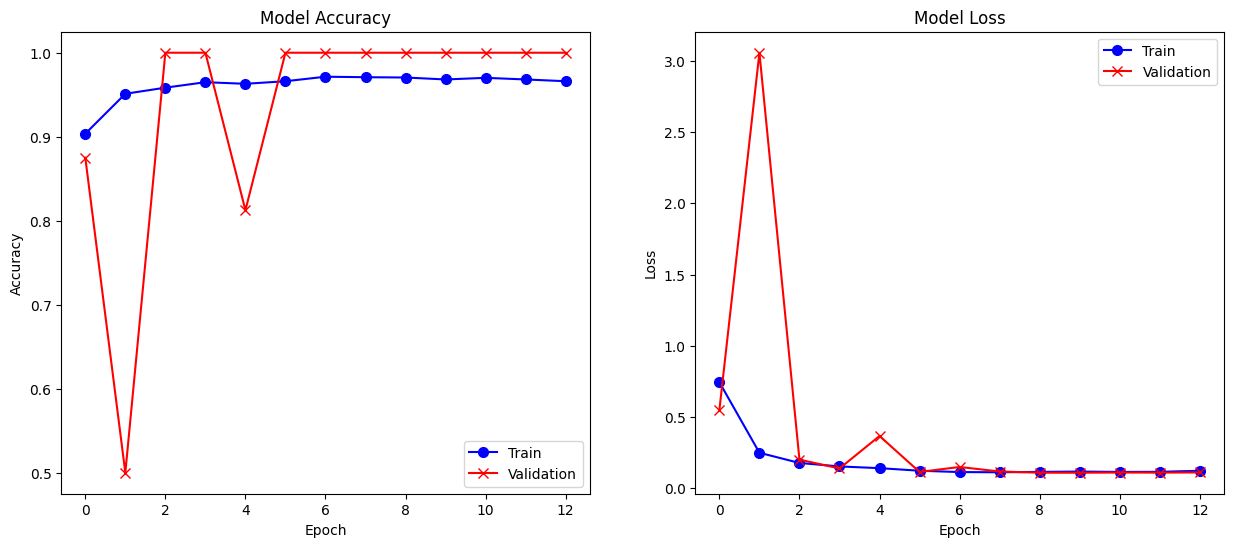

In [ ]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# accuracy

ax[0].plot(history.history['accuracy'], marker = 'o', color = 'blue', markersize = 7)
ax[0].plot(history.history['val_accuracy'], marker = 'x', color = 'red', markersize = 7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# loss

ax[1].plot(history.history['loss'], marker = 'o', color = 'blue', markersize = 7)
ax[1].plot(history.history['val_loss'], marker = 'x', color = 'red', markersize = 7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

plt.show()

<Figure size 1000x1000 with 0 Axes>

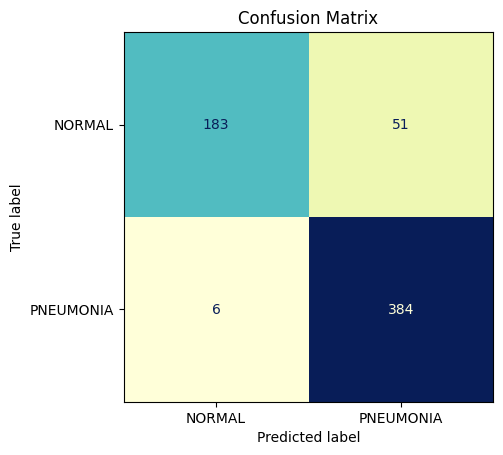

In [ ]:
test_matrix = confusion_matrix(test_classes, predicted_classes)

class_labels = list(test_images.class_indices.keys())

disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

plt.figure(figsize = (10, 10))

disp_test.plot(cmap = 'YlGnBu', colorbar = False)
plt.title('Confusion Matrix')

plt.show()

Our model's performance is acceptable; however, the values for False Positives (FP) and False Negatives (FN) are high due to class imbalance. Further fine-tuning or augmentation may help correct this issue. Nonetheless, our primary concern should not solely be on False Positives, but on False Negatives, which have a value of 9. In a real-world scenario, out of 400 pneumonia-infected patients, 9 would go undetected. While this number may not seem significant, it poses a serious concern as it can lead to further health complications for unchecked patients.